### Imports
https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tsfresh

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

%run plot.py

### Read data

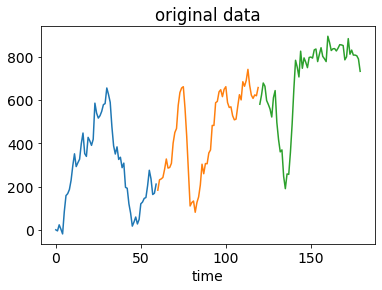

data:  10000


In [ ]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y))
print('data: ',N)

### (do not) Rescale data
We know that the average value of a sample is not relevant: let's see if XGBoost works if we do not remove such average and we do not standardize data

In [ ]:
RESCALE=False
if RESCALE:
    #remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    #rescale (crude version, variance should be used)
    x = x/400

    Show_data(x,L,"rescaled data")

## TSFRESH: extract features

Input data format: DATAFRAME

first column $\to$ id of the sample 

second column $\to$  id of the time step

third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

In [ ]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [ ]:
#get df
df = get_df(x) 

#check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df

,id,time,value
0,0,0,0.0
1,0,1,-5.0
2,0,2,23.0
3,0,3,3.0
4,0,4,-19.0
...,...,...,...
599995,9999,55,2977193.0
599996,9999,56,2977276.0
599997,9999,57,2977286.0
599998,9999,58,2977386.0


In [ ]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction: 100%|██████████| 20/20 [09:01<00:00, 27.10s/it]


In [ ]:
#look at x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,16750.0,6.729150e+06,43.101695,3.576271,0.405172,289.5,...,3.608440,3.809279,NaN,0.731923,3.235582,1.491836,1.414559,1.093670,1.850822,5.945714e+02
1,1.0,0.0,0.0,1.0,27302.0,1.455619e+07,44.000000,8.033898,-0.086207,509.5,...,3.462655,3.659720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.811429e+02
2,1.0,0.0,0.0,1.0,41650.0,3.090479e+07,45.491525,2.576271,-0.862069,784.0,...,4.007333,3.988984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.632857e+02
3,1.0,0.0,0.0,1.0,37428.0,2.393510e+07,44.372881,-2.169492,1.008621,631.0,...,3.871793,3.937640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.844286e+02
4,1.0,0.0,0.0,1.0,58260.0,6.072359e+07,54.593220,10.728814,-0.422414,909.0,...,3.575507,3.773917,NaN,0.798380,4.985956,2.381229,1.596584,1.268636,4.166435,1.389857e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.0,0.0,1.0,178577898.0,5.315011e+14,44.898305,3.813559,-0.232759,2976394.0,...,3.619739,3.789900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976477e+06
9996,1.0,0.0,0.0,1.0,178600157.0,5.316336e+14,40.288136,10.694915,-0.758621,2976629.0,...,3.786663,3.876606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.977001e+06
9997,1.0,0.0,0.0,1.0,178618515.0,5.317429e+14,48.915254,-1.423729,-0.422414,2976910.5,...,3.634172,3.876606,NaN,0.884993,2.726286,1.579071,1.633772,1.125823,1.869142,2.977446e+06
9998,1.0,0.0,0.0,1.0,178611894.0,5.317035e+14,57.677966,-0.762712,0.577586,2976930.0,...,3.639092,3.757935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.977054e+06


In [ ]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [ ]:
#look at clean x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,16750.0,6.729150e+06,43.101695,3.576271,0.405172,289.5,...,0.283936,0.424254,0.424254,0.980757,1.606551,2.560840,3.232518,3.608440,3.809279,5.945714e+02
1,1.0,0.0,0.0,1.0,27302.0,1.455619e+07,44.000000,8.033898,-0.086207,509.5,...,0.379535,0.379535,0.518700,1.107653,1.547018,2.436717,3.108691,3.462655,3.659720,6.811429e+02
2,1.0,0.0,0.0,1.0,41650.0,3.090479e+07,45.491525,2.576271,-0.862069,784.0,...,0.142506,0.379535,0.424254,1.107653,1.745508,2.930054,3.743700,4.007333,3.988984,8.632857e+02
3,1.0,0.0,0.0,1.0,37428.0,2.393510e+07,44.372881,-2.169492,1.008621,631.0,...,0.473981,0.687083,1.320351,2.757282,1.695334,2.879917,3.584589,3.871793,3.937640,7.844286e+02
4,1.0,0.0,0.0,1.0,58260.0,6.072359e+07,54.593220,10.728814,-0.422414,909.0,...,0.379535,0.424254,0.656671,0.838120,1.668815,2.785780,3.277698,3.575507,3.773917,1.389857e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.0,0.0,1.0,178577898.0,5.315011e+14,44.898305,3.813559,-0.232759,2976394.0,...,0.283936,0.424254,0.563420,1.134027,1.588719,2.476201,3.245121,3.619739,3.789900,2.976477e+06
9996,1.0,0.0,0.0,1.0,178600157.0,5.316336e+14,40.288136,10.694915,-0.758621,2976629.0,...,0.142506,0.283936,0.424254,1.237411,1.655861,2.603521,3.355240,3.786663,3.876606,2.977001e+06
9997,1.0,0.0,0.0,1.0,178618515.0,5.317429e+14,48.915254,-1.423729,-0.422414,2976910.5,...,0.379535,0.424254,0.656671,0.928839,1.657902,2.624445,3.267602,3.634172,3.876606,2.977446e+06
9998,1.0,0.0,0.0,1.0,178611894.0,5.317035e+14,57.677966,-0.762712,0.577586,2976930.0,...,0.457102,0.656671,0.838120,0.973558,1.643572,2.582843,3.294830,3.639092,3.757935,2.977054e+06


### Split train/val

In [ ]:
#split data into training and validation

#perc_train=0.8
#N_train = int(perc_train*N)
#x_train = x_features[:N_train]
#y_train = y[:N_train]
#x_val = x_features[N_train:]
#y_val = y[N_train:]
#N_val = len(x_val)
#print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#split data into train and valid for independent train and test
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=12345, stratify=y)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_valid -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_valid /= std

In [ ]:
#look at x_train
x_train

array([[ 0.44240553,  0.4424082 ,  0.44236259, ...,  0.44260705,
         0.44261735,  0.44260325],
       [-1.04240755, -1.04251093, -1.04247052, ..., -1.04213157,
        -1.04217265, -1.04223131],
       [-0.85316247, -0.85312196, -0.85315877, ..., -0.85287452,
        -0.85285925, -0.85290054],
       ...,
       [-0.38658162, -0.38661817, -0.38651252, ..., -0.38569455,
        -0.38573351, -0.3857354 ],
       [-0.48725489, -0.48714873, -0.48715697, ..., -0.48749081,
        -0.48751938, -0.48752479],
       [ 1.49623544,  1.49620829,  1.4962392 , ...,  1.49628925,
         1.4962164 ,  1.49621899]])

## XGB

In [ ]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train,y_train)

XGBClassifier(learning_rate=0.3, max_depth=6, objective='multi:softprob',
              use_label_encoder=False)

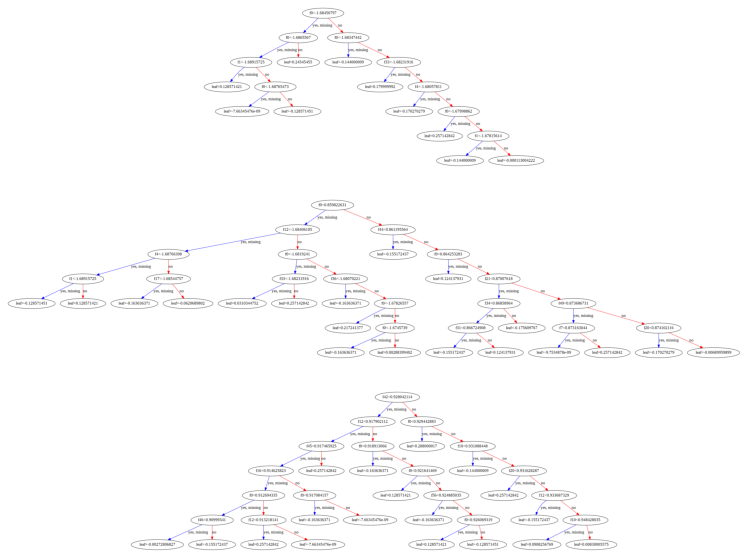

In [ ]:
#plot tree

fig, AX = plt.subplots(3,1,figsize=(30, 10))
for i in range(3):
    ax=AX[i]
    plot_tree(model, num_trees=i, ax=ax)
    
fig.savefig("DATA/trees-time-ser.png", dpi=300, pad_inches=0.02)

In [ ]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = model.predict(x_train)
#predict labels on validation set
y_pred_val = model.predict(x_valid)

y_pred_val_soft = model.predict_proba(x_valid)



#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_valid,y_pred_val)

#print accuracies
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)

Training accuracy: 0.521375
Validation accuracy: 0.2205


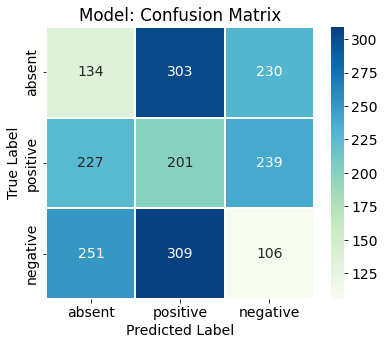

In [ ]:
import seaborn as sns
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_valid)
show_confusion_matrix(y_valid, y_pred_val)

### Feature importances

See an overview of extracted features:
https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [ ]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

IndexError: ignored

In [ ]:
minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0000001
------------- Showing feature with importance > 0.005
1 value__variance_larger_than_standard_deviation 0.015787711
2 value__has_duplicate_max 0.015552722
3 value__has_duplicate_min 0.01738828
4 value__has_duplicate 0.017136259
5 value__sum_values 0.014586732
6 value__abs_energy 0.01870261
7 value__mean_abs_change 0.015178688
8 value__mean_change 0.022546437
9 value__mean_second_derivative_central 0.011753913
10 value__median 0.016608182
11 value__mean 0.017359447
12 value__length 0.016484497
13 value__standard_deviation 0.015102388
14 value__variation_coefficient 0.016413206
15 value__variance 0.01473393
16 value__skewness 0.020515611
17 value__kurtosis 0.013158599
18 value__root_mean_square 0.014935399
19 value__absolute_sum_of_changes 0.013599582
20 value__longest_strike_below_mean 0.016889961
21 value__longest_strike_above_mean 0.019144
22 value__count_above_mean 0.016514516
23 value__count_below_mean 0.020692114
24 value__last_locati

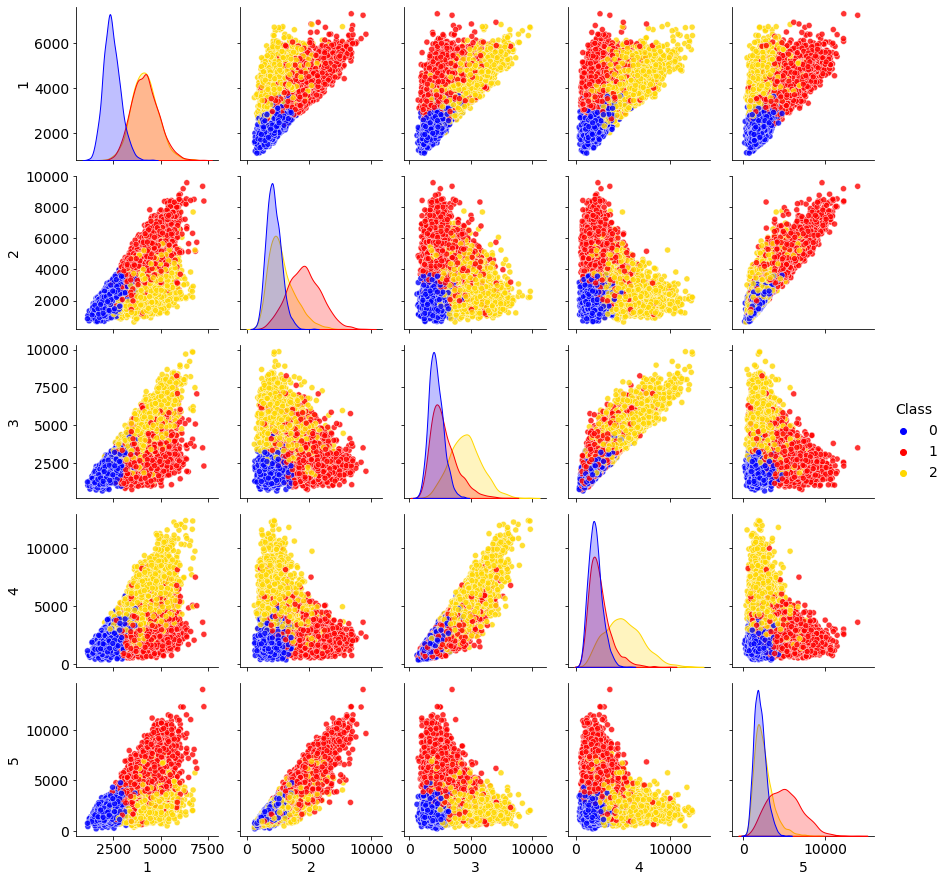

In [ ]:
#get feature names given importance order
features = list(feat_imp.keys())

#build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':y})
#pairplot with seaborn
pal = sns.blend_palette(["blue","red","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);